In [2]:
import re
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal, getcontext
from scipy.interpolate import interp1d
import plotly.graph_objects as go
import plotly.io as pio
from scipy.optimize import fsolve
import pandas as pd

In [3]:
#This is a function specifically designed for reading the dat type exported from Comsol
#However, depending on the content you select to output in Comsol, the code needs to be adjusted

def load_comsol_data(file_path):
    # Initialize a dictionary to store the data
    data_dict = {}

    # Define the column names
    column_names = ["Effective_mode_index", "Eigenvalue", "real_ewfd_neff", "Frequency_Hz"]
    daddy_array = np.repeat(np.arange(1, 402), 5)
    # Read the file and process each line
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for i,line in enumerate(lines[5:]):  # Skip header lines
            # Split the line into parts, handling the complex numbers properly
            parts = line.strip().split(maxsplit=4)  # Split only the first 4 parts to handle complex numbers
            daddy = daddy_array[i]
            Effective_mode_index = parts[1]
            Eigenvalue = parts[2]
            real_ewfd_neff = parts[3]
            Frequency_Hz = parts[4]

            # Create a DataFrame row
            row_df = pd.DataFrame([[Effective_mode_index, Eigenvalue, real_ewfd_neff, Frequency_Hz]], columns=column_names)
            
            # Add to the dictionary
            if daddy not in data_dict:
                data_dict[daddy] = row_df
            else:
                data_dict[daddy] = pd.concat([data_dict[daddy], row_df], ignore_index=True)

    return data_dict

In [4]:
file_path = r"C:\Users\Eric\Desktop\Caltech\photogalvanic_atCaltech\SHG\Group Velocity Dispersion Python Code\data\Ge_silica_400nm2nm1200nm.dat"
comsol_data = load_comsol_data(file_path)


In [5]:
comsol_data

{1:                        Effective_mode_index  \
 0  1.4927402583117704-5.14933948416096E-15i   
 1                         1.493191718562033   
 2                        1.4932014135410283   
 3                        1.4934654735474444   
 4                        1.4934780405914803   
 
                                     Eigenvalue      real_ewfd_neff  \
 0  -8.088563547139962E-8-2.3447909146149937E7i  1.4927402583117704   
 1                       -2.3455000667177998E7i   1.493191718562033   
 2                        -2.345515295555194E7i  1.4932014135410283   
 3                        -2.345930080043326E7i  1.4934654735474444   
 4                       -2.3459498203099363E7i  1.4934780405914803   
 
            Frequency_Hz  
 0  7.494811449999999E14  
 1  7.494811449999999E14  
 2  7.494811449999999E14  
 3  7.494811449999999E14  
 4  7.494811449999999E14  ,
 2:                          Effective_mode_index  \
 0  1.4927251696411399-2.8365962662602816E-14i   
 1           

In [7]:
keep_only_max = {}
for a in comsol_data.keys():
    df = comsol_data[a]
    df['real_ewfd_neff'] = pd.to_numeric(df['real_ewfd_neff'], errors='coerce')
    max_index = df['real_ewfd_neff'].idxmax()
    max_row = df.loc[[max_index]]
    keep_only_max[a] = max_row

In [8]:

combined_df = pd.concat(keep_only_max.values(), ignore_index=True)
combined_df['Frequency_Hz'] = pd.to_numeric(combined_df['Frequency_Hz'], errors='coerce')
combined_df['real_ewfd_neff'] = pd.to_numeric(combined_df['real_ewfd_neff'], errors='coerce')
c = Decimal('3e8')
getcontext().prec = 50
frequencies_decimal = combined_df['Frequency_Hz'].apply(lambda f: Decimal(str(f)) if not pd.isna(f) else Decimal('NaN'))
wavelength_nm = frequencies_decimal.apply(lambda f: (c / f) * Decimal('1e9') if f != Decimal('NaN') else Decimal('NaN'))
neff = combined_df['real_ewfd_neff'] 

combined_df['wavelength']  = wavelength_nm
combined_df

,Effective_mode_index,Eigenvalue,real_ewfd_neff,Frequency_Hz,wavelength
0,1.4934780405914803,-2.3459498203099363E7i,1.493478,7.494811e+14,400.276914237782512897894747943594084397513154...
1,1.4934703214946285,-2.334266363364135E7i,1.493470,7.457524e+14,402.278298808971379570910129740602085164126285...
2,1.4934625709237257,-2.3226985352600504E7i,1.493463,7.420605e+14,404.279683380160281927947989244424384136051939...
3,1.4934547889400658,-2.3112446272919238E7i,1.493455,7.384051e+14,406.281067951349219150542945222013829744581098...
4,1.4934469756048323,-2.29990296425786E7i,1.493447,7.347854e+14,408.282452522538110859519768292706607633310205...
...,...,...,...,...,...
396,1.472296417452128,-7760663.773446606i,1.472296,2.515037e+14,1192.82520442859175792988585418603378306194130...
397,1.4722581844227152,-7747463.14299807i,1.472258,2.510825e+14,1194.82658899978079813064682204710350175589530...
398,1.4722199231309385+1.9486468753716308E-16i,1.02372152309502E-9-7734306.513338939i,1.472220,2.506626e+14,1196.82797357096976626159219114041743210466144...
399,1.4721816301857522,-7721193.646312862i,1.472182,2.502441e+14,1198.82935814215847393241945664886419333769145...


In [10]:
combined_df['real_ewfd_neff'][0]

1.4934780405914805

In [31]:
wavelength_nm[67]

Decimal('534.36968050743967247204477089175484429083520757574')

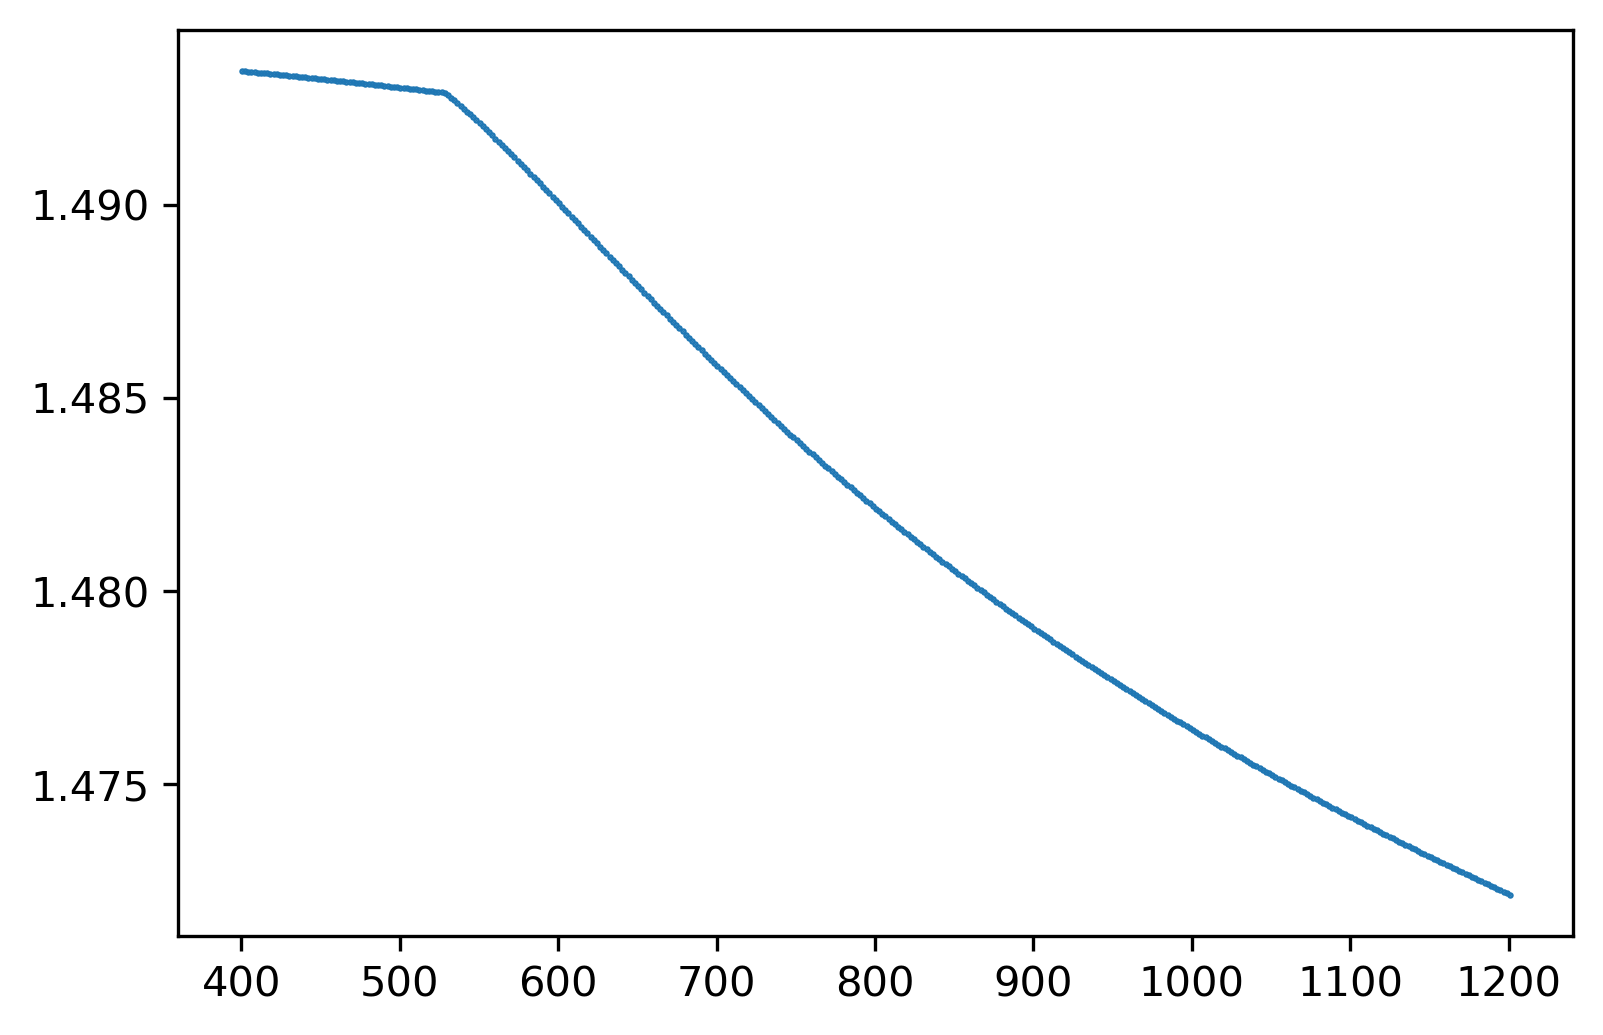

In [12]:
plt.figure(dpi=300)
plt.scatter(wavelength_nm,neff,s=0.3)

'''
    D = - lambda / c * d/dlambda d/dlambda neff

I want you to do numerical second order derivative and get the plot of D v.s. wavelength
'''
# Create the scatter plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=wavelength_nm,
    y=neff,
    mode='markers',
    marker=dict(size=3),  # Adjust marker size as needed
    name='neff vs. wavelength'
))

# Set plot title and labels
fig.update_layout(
    title='Effective Index vs. Wavelength',
    xaxis_title='Wavelength (nm)',
    yaxis_title='Effective Index (neff)',
    template='plotly_white'
)

# Show the plot
fig.show()

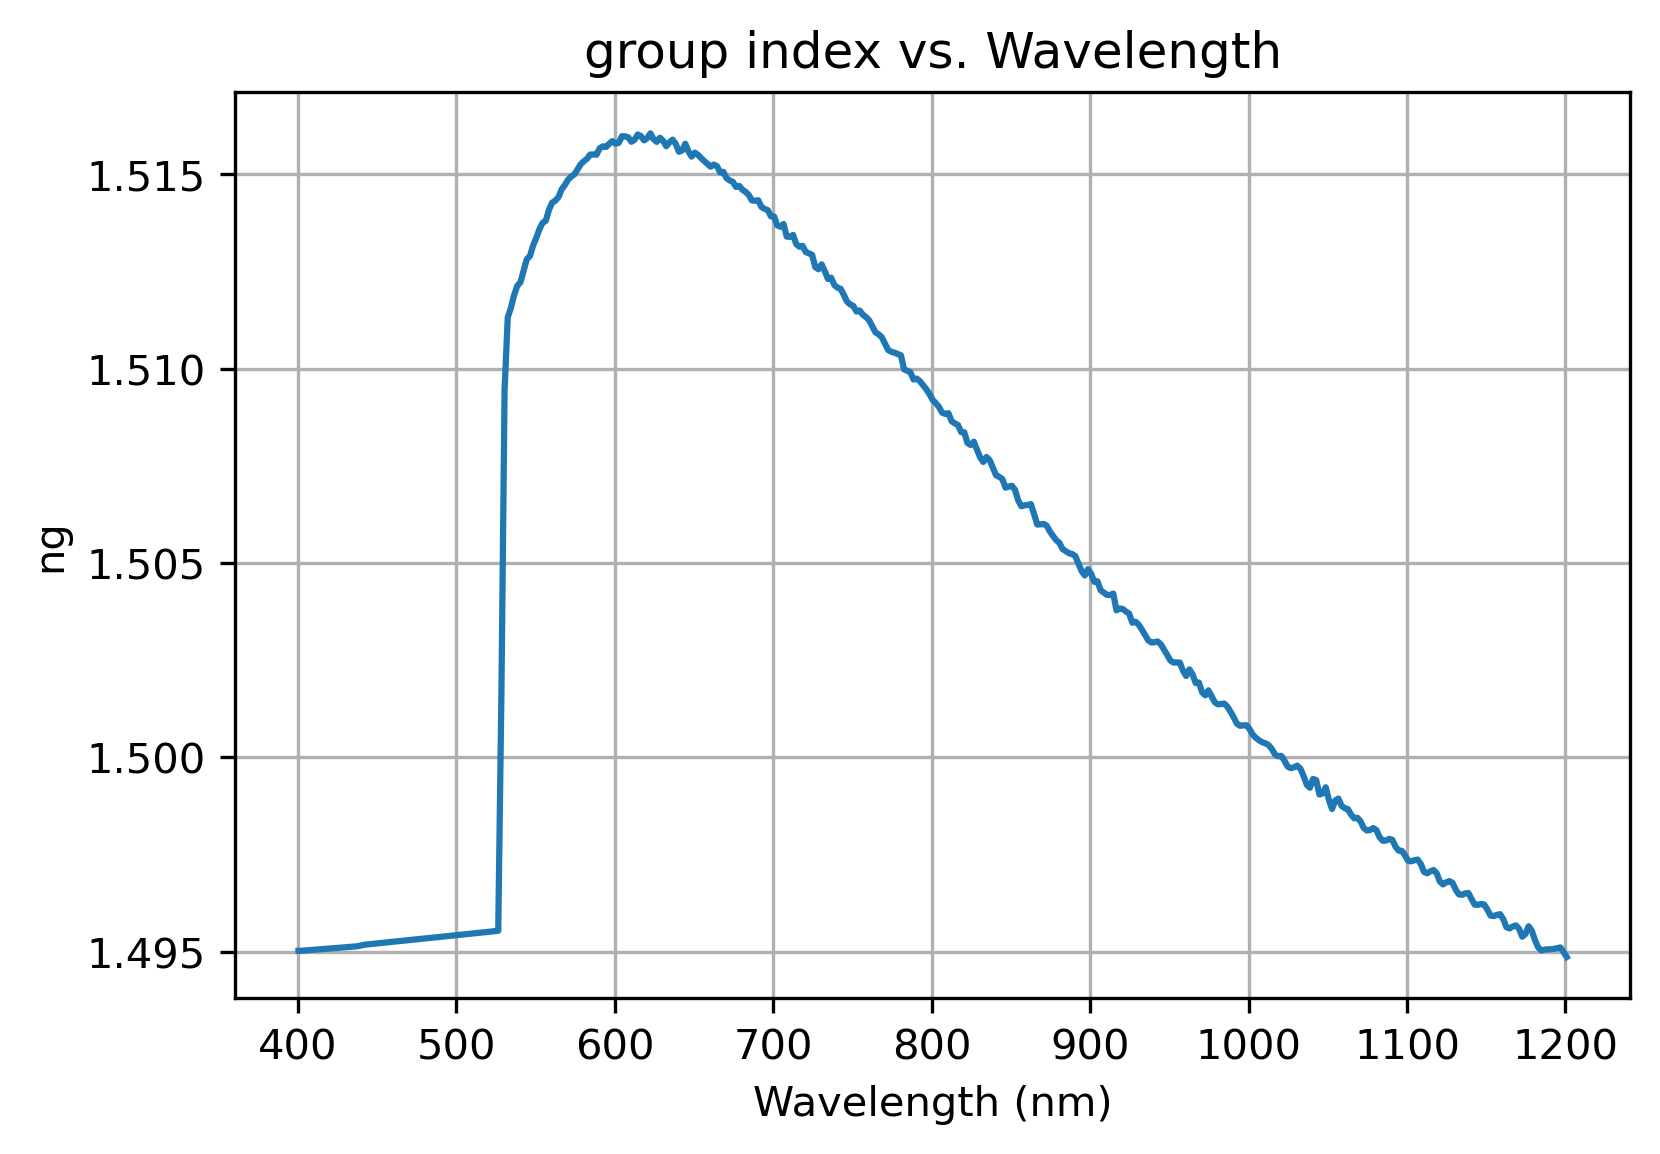

In [15]:

# Assuming keep_only_max is a dictionary of DataFrames
combined_df = pd.concat(keep_only_max.values(), ignore_index=True)
combined_df['Frequency_Hz'] = pd.to_numeric(combined_df['Frequency_Hz'], errors='coerce')
combined_df['real_ewfd_neff'] = pd.to_numeric(combined_df['real_ewfd_neff'], errors='coerce')

# Define speed of light in m/s as a Decimal for high-precision calculation
c = Decimal('3e8')

# Set precision for Decimal calculations
getcontext().prec = 100

# Convert frequencies to Decimal for high-precision calculation
frequencies_decimal = combined_df['Frequency_Hz'].apply(lambda f: Decimal(str(f)) if not pd.isna(f) else Decimal('NaN'))

# Calculate wavelength in nm with high precision
wavelength_nm = frequencies_decimal.apply(lambda f: (c / f) * Decimal('1e9') if f != Decimal('NaN') else Decimal('NaN'))

# Convert wavelength_nm and neff to numpy arrays for numerical operations
wavelength_nm = np.array(wavelength_nm.tolist(), dtype=np.float64)
neff = combined_df['real_ewfd_neff'].to_numpy()

'''
fine_wavelength_grid = np.linspace(np.min(wavelength_nm[67:400]), np.max(wavelength_nm[67:400]), 5000)
interpolator = interp1d(wavelength_nm[67:400], neff[67:400], kind='cubic')
fine_neff = interpolator(fine_wavelength_grid)
'''






# Calculate second-order numerical derivative using central difference method
dndlambda = np.gradient(neff, wavelength_nm)

# Compute D
#ng = fine_neff - fine_wavelength_grid * dndlambda
ng=neff - wavelength_nm*dndlambda
# Plot D vs. wavelength
plt.figure(dpi=300)
plt.plot(wavelength_nm, ng)
plt.xlabel('Wavelength (nm)')
plt.ylabel('ng')
plt.title('group index vs. Wavelength')
plt.grid(True)
plt.show()

In [16]:
# Create the figure
fig = go.Figure()

# Add neff vs. wavelength scatter plot
fig.add_trace(go.Scatter(
    x=wavelength_nm,
    y=neff,
    mode='markers',
    marker=dict(size=3),
    name='neff vs. wavelength'
))

# Add ng vs. fine_wavelength_grid line plot
fig.add_trace(go.Scatter(
    x=wavelength_nm,
    y=ng,
    mode='lines',
    name='ng vs. wavelength'
))

# Update layout with titles and labels
fig.update_layout(
    title='Effective Index and Group Index vs. Wavelength',
    xaxis_title='Wavelength (nm)',
    yaxis_title='Index',
    template='plotly_white',
    legend_title='Legend'
)

# Save the plot as an HTML file
fig.write_html("neff_ng.html")

# Show the plot
fig.show()

In [17]:
len(wavelength_nm)

401

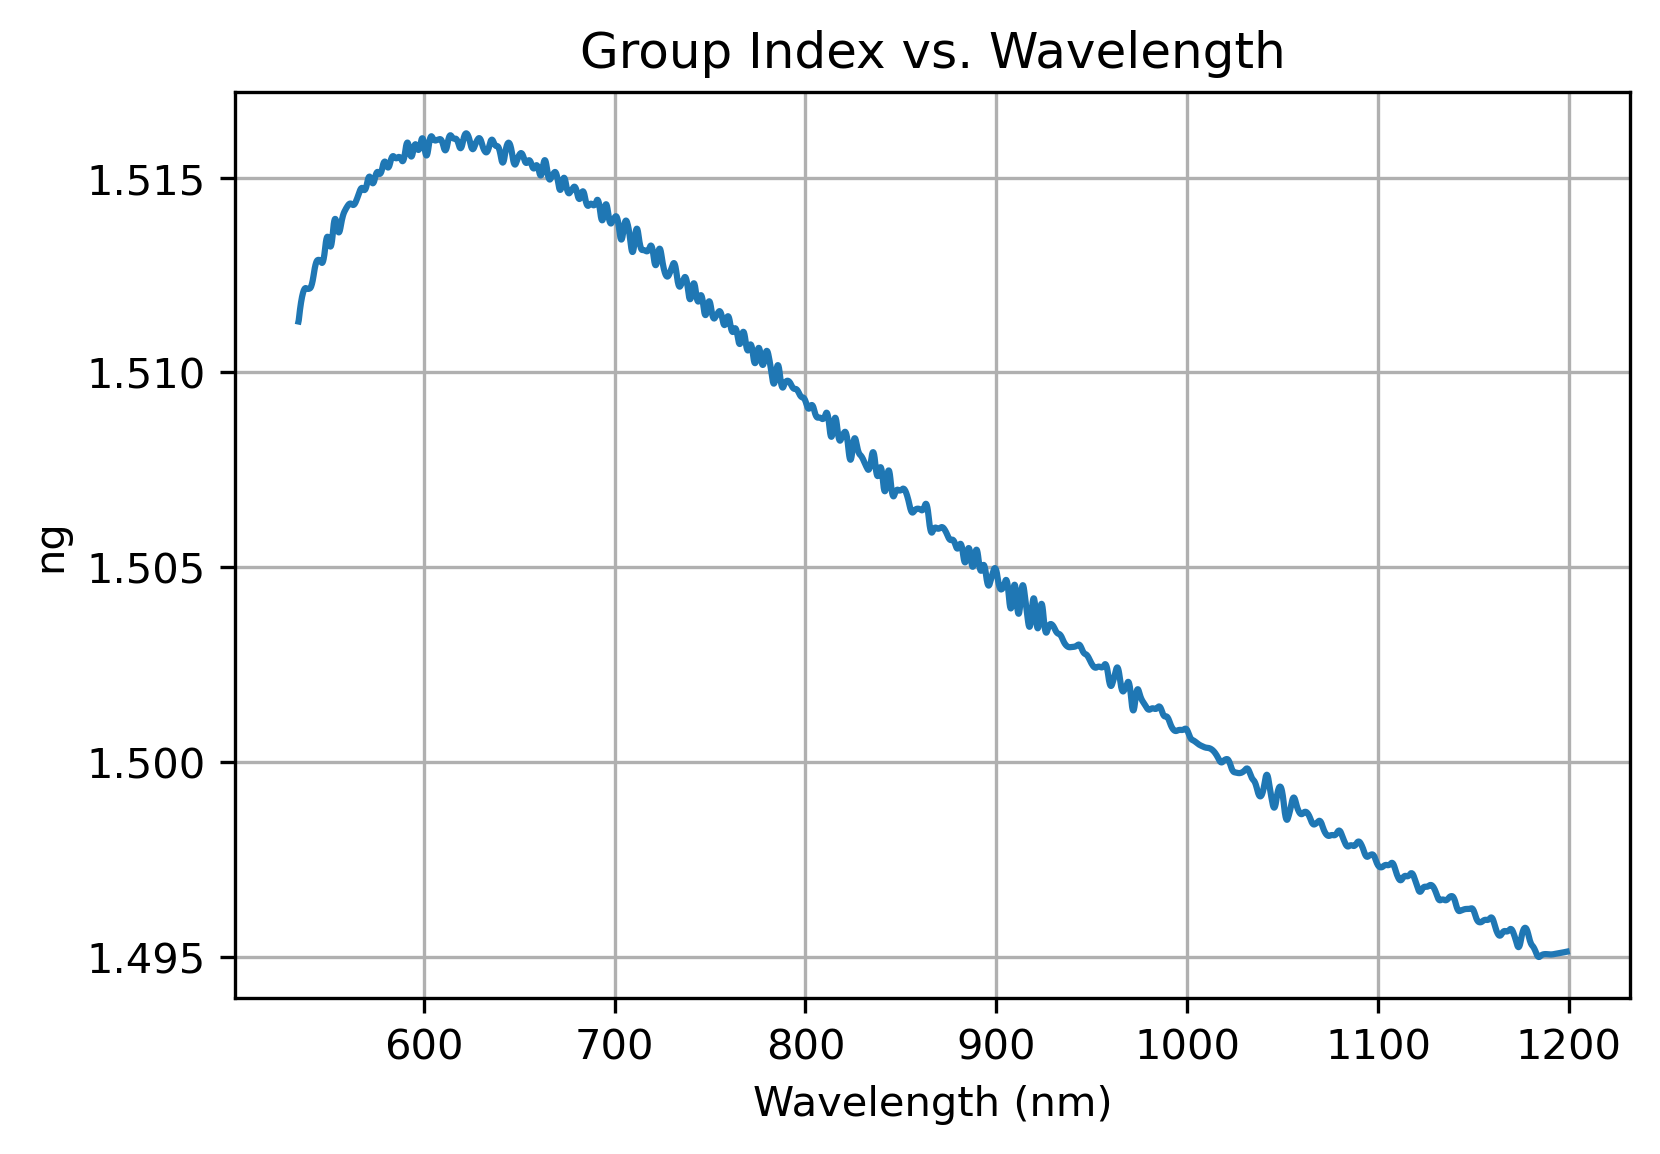

In [36]:
import pandas as pd
import numpy as np
from decimal import Decimal, getcontext
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Assuming keep_only_max is a dictionary of DataFrames
combined_df = pd.concat(keep_only_max.values(), ignore_index=True)
combined_df['Frequency_Hz'] = pd.to_numeric(combined_df['Frequency_Hz'], errors='coerce')
combined_df['real_ewfd_neff'] = pd.to_numeric(combined_df['real_ewfd_neff'], errors='coerce')

# Define speed of light in m/s as a Decimal for high-precision calculation
c = Decimal('3e8')

# Set precision for Decimal calculations
getcontext().prec = 100

# Convert frequencies to Decimal for high-precision calculation
frequencies_decimal = combined_df['Frequency_Hz'].apply(lambda f: Decimal(str(f)) if not pd.isna(f) else Decimal('NaN'))

# Calculate wavelength in nm with high precision
wavelength_nm = frequencies_decimal.apply(lambda f: (c / f) * Decimal('1e9') if f != Decimal('NaN') else Decimal('NaN'))

# Convert wavelength_nm and neff to numpy arrays for numerical operations
wavelength_nm = np.array(wavelength_nm.tolist(), dtype=np.float64)
neff = combined_df['real_ewfd_neff'].to_numpy()

# Define the range for the fine wavelength grid
fine_wavelength_grid = np.linspace(np.min(wavelength_nm[67:400]), np.max(wavelength_nm[67:400]), 5000)

# Interpolate neff values on the fine wavelength grid
interpolator = interp1d(wavelength_nm[67:400], neff[67:400], kind='cubic')
fine_neff = interpolator(fine_wavelength_grid)

# Calculate the first-order and second-order gradients using central difference method
h = fine_wavelength_grid[1] - fine_wavelength_grid[0]
dndlambda = np.gradient(fine_neff, h)

# Compute the group index ng
ng = fine_neff - fine_wavelength_grid * dndlambda

# Plot ng vs. fine_wavelength_grid
plt.figure(dpi=300)
plt.plot(fine_wavelength_grid, ng)
plt.xlabel('Wavelength (nm)')
plt.ylabel('ng')
plt.title('Group Index vs. Wavelength')
plt.grid(True)
plt.show()


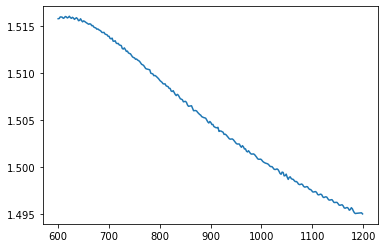

In [19]:

plt.plot(wavelength_nm[100:400],ng[100:400])

1.5113796729181446


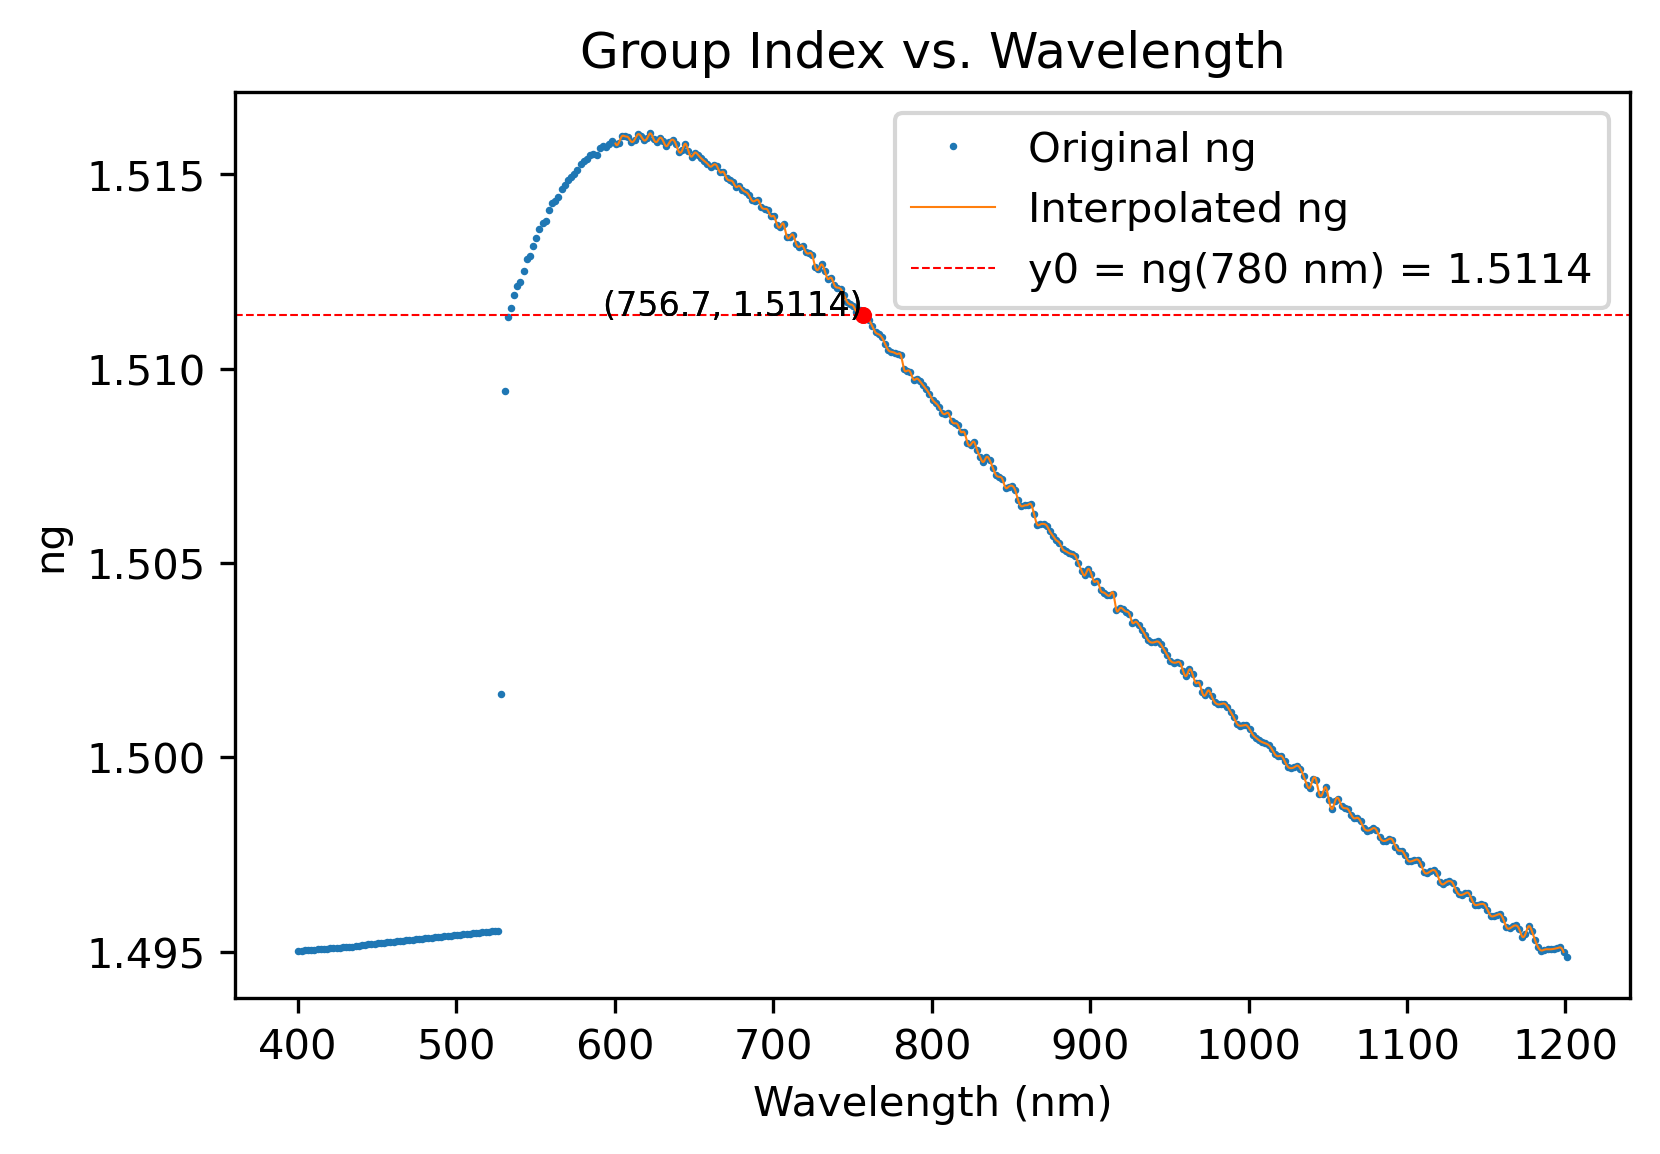

In [20]:
fine_wavelength_grid = np.linspace(np.min(wavelength_nm[100:400]), np.max(wavelength_nm[100:400]), 8000)
ng_interpolator = interp1d(wavelength_nm[100:400], ng[100:400], kind='cubic')
fine_ng = ng_interpolator(fine_wavelength_grid)


y0 = ng_interpolator(756.7)
def find_intersections(x):
    return ng_interpolator(x) - y0
initial_guesses = [780, 1000]
intersections = fsolve(find_intersections, initial_guesses)


print(y0)

# Plot the non-interpolated and interpolated ng vs. wavelength
plt.figure(dpi=300)
plt.plot(wavelength_nm, ng, 'o', label='Original ng', markersize=0.8)
plt.plot(fine_wavelength_grid, fine_ng, '-', label='Interpolated ng',linewidth=0.5)
plt.axhline(y=y0, color='r', linestyle='--', label=f'y0 = ng(780 nm) = {y0:.4f}',linewidth=0.5)
for x in intersections:
    y = ng_interpolator(x)
    plt.plot(x, y, 'ro',markersize=3)
    plt.text(x, y, f'({x:.1f}, {y:.4f})', fontsize=8, ha='right')

plt.xlabel('Wavelength (nm)')
plt.ylabel('ng')
plt.title('Group Index vs. Wavelength')
plt.legend()
plt.show()